## Purpose of module

This module uses the technique described in 'Online short-term solar forecasting' by Bacher P, Madsen H & Nielsen HA (2009) to normalise the mean direct horizontal radiation by dividing by a clear sky model, created by smoothing the data in two dimensions; day of the year and hour of the day. 

## Import modules and load data

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import distance
from scipy import asarray as ar,exp
import numpy as np
import os
import pandas as pd
import patsy
import pylab as plb
import pytz
#import pyephem
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

%matplotlib inline

In [2]:
PV = pd.read_csv('..//solar_data/PV_2017.csv',parse_dates=['date_time'], index_col='date_time')

In [3]:
use_cols = ['mean_dir_horiz','mean_diffuse'] # Assuming the sum of these is the same as Global Horizontal Irradiance (GHI)
PV = PV[use_cols]

In [4]:
PV.head()

,mean_dir_horiz,mean_diffuse
date_time,,
2017-01-01 00:00:00,0.0,0.0
2017-01-01 00:01:00,0.0,0.0
2017-01-01 00:02:00,0.0,0.0
2017-01-01 00:03:00,0.0,0.0
2017-01-01 00:04:00,0.0,0.0


In [5]:
PV['GHI'] = PV.mean_dir_horiz + PV.mean_diffuse

In [77]:
# Check range of data
print('from:',PV.iloc[0].name,'to:',PV.iloc[-1].name)

from: 2017-01-01 00:00:00 to: 2017-12-31 23:59:00


### Resample from 1 minute frequency to 15 minute frequency to speed up calculation times

In [7]:
# Resample only columns derived from the DatetimeIndex
PV_15M = PV.resample('15T').mean()

In [8]:
PV_15M.head()

,mean_dir_horiz,mean_diffuse,GHI
date_time,,,
2017-01-01 00:00:00,0.0,0.0,0.0
2017-01-01 00:15:00,0.0,0.0,0.0
2017-01-01 00:30:00,0.0,0.0,0.0
2017-01-01 00:45:00,0.0,0.0,0.0
2017-01-01 01:00:00,0.0,0.0,0.0


## Deal with missing data

Count missing values

In [72]:
np.isnan(PV_15M).sum()

mean_dir_horiz           875
mean_diffuse             850
GHI                      880
time_of_day                0
day_of_year                0
summer_solstice_delta      0
midday_delta               0
dtype: int64

In [73]:
PV_15M[np.isnan(PV_15M.GHI)].head()

,mean_dir_horiz,mean_diffuse,GHI,time_of_day,day_of_year,summer_solstice_delta,midday_delta
date_time,,,,,,,
2017-01-30 00:15:00,NaN,NaN,NaN,16.0,30,-39,-705.0
2017-01-30 00:30:00,NaN,NaN,NaN,31.0,30,-39,-690.0
2017-01-30 00:45:00,NaN,NaN,NaN,46.0,30,-39,-675.0
2017-01-30 01:00:00,NaN,NaN,NaN,61.0,30,-39,-660.0
2017-01-30 01:15:00,NaN,NaN,NaN,76.0,30,-39,-645.0


How should we deal with missing data here?  The data is being used to fit a regression plane.  

* Setting missing values to zero would distort the regression coefficients.
* Imputing missing values require a regression plane (chicken and egg problem).
* Replacing with the mean/median would also distort the regression coefficients (reduce variance).
* Deleting missing values means we can no longer neatly pack the data into an $x$ (day of year) by $y$ (time of day) array to calculate the objective function.
* Can we just leave missing values in for the time being? After packing the data into an $x$ by $y$ array, $z$ (actual solar power at the corresponding value of $x$ and $y$) will have missing data at some points, but $\hat z$ will not. Our objective/loss function then ignore those points on the $x$ by $y$ grid where there are missing values for $z$.

Lui suggested replacement of missing values with the same time and date from the prior year.

In [ ]:
### Import last year's data
### Check that corresponding dates and times are not missing
### If not, replace missing values in 2017 with corresponding values in 2016

## Create new variables for analysis

Add time of day (in minutes from midnight at the start of each day):

In [11]:
PV_15M['time_of_day'] = PV_15M.index.map(lambda x: (
    x.combine(x.date(),x.time()) - x.combine(x.date(),dt.time(0,0))).seconds / 60 + 1)

Add day of year beginning 1 January:

In [12]:
first_day_of_year = dt.date(2017,1,1)
PV_15M['day_of_year'] = PV_15M.index.map(lambda x: (x.date() - first_day_of_year).days + 1)

Bacher, Madsen and Nielsen recommend fitting $z$ (clear sky solar power) to the $q^{th}$ quantile of a normal distribution in two dimensions to the data ($x$ = day of year and $y$ = time of day) to create a clear sky model. The normal distribution is centred around zero, hence we have done the same to our regressors, as follows.

Let each (solar) year be delimited by winter solstices, so the summer solstice falls in the middle of each year. Within each year, define `summer_solstice_delta` as the distance, in days, from the summer solstice.

In [13]:
winter_solstice = (6,21) # 21 June
summer_solstice = (12,22) # 22 December

In [14]:
def summer_solstice_delta(qdate):
    if qdate < dt.date(qdate.year,*winter_solstice): # Is date in last solar year?
        return (dt.date(qdate.year-1,*summer_solstice) - qdate).days # If so, return delta from last year's summer solstice
    else:
        return (dt.date(qdate.year,*summer_solstice) - qdate).days # Otherwise return delta from this year's summer solstice

PV_15M['summer_solstice_delta'] = PV_15M.index.map(lambda x: summer_solstice_delta(x.date()))

Similarly, define `midday_delta` as the distance, in minutes, from midday each day.

In [15]:
def midday_delta(time_of_day):
    return time_of_day - 12*60-1

PV_15M['midday_delta'] = midday_delta(PV_15M.time_of_day)

In [16]:
PV_15M.head()

,mean_dir_horiz,mean_diffuse,GHI,time_of_day,day_of_year,summer_solstice_delta,midday_delta
date_time,,,,,,,
2017-01-01 00:00:00,0.0,0.0,0.0,1.0,1,-10,-720.0
2017-01-01 00:15:00,0.0,0.0,0.0,16.0,1,-10,-705.0
2017-01-01 00:30:00,0.0,0.0,0.0,31.0,1,-10,-690.0
2017-01-01 00:45:00,0.0,0.0,0.0,46.0,1,-10,-675.0
2017-01-01 01:00:00,0.0,0.0,0.0,61.0,1,-10,-660.0


### Visualise dataset

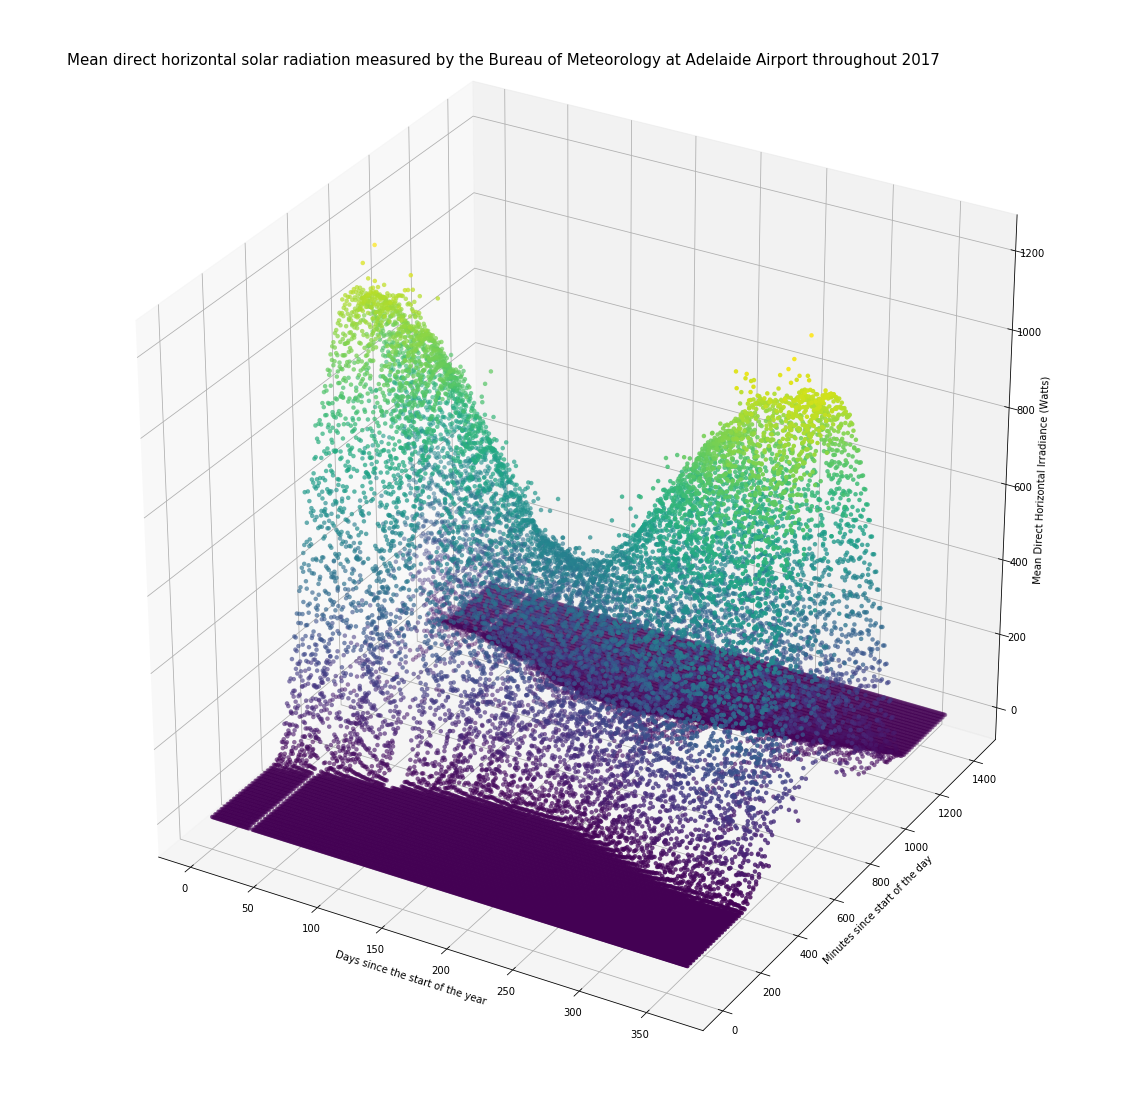

In [78]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_15M.day_of_year, PV_15M.time_of_day, PV_15M.GHI, 
                c=PV_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since the start of the year')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

__Observations__

* There is at least a day's missing data in late January.
* Some points sit well above the surface, likely due to the effect described by Luigi Cirocco and John Boland where reflection and magnification by cloud creates solar power above the 'clear sky solar power'.
* Otherwise, the data distribution is as expected.

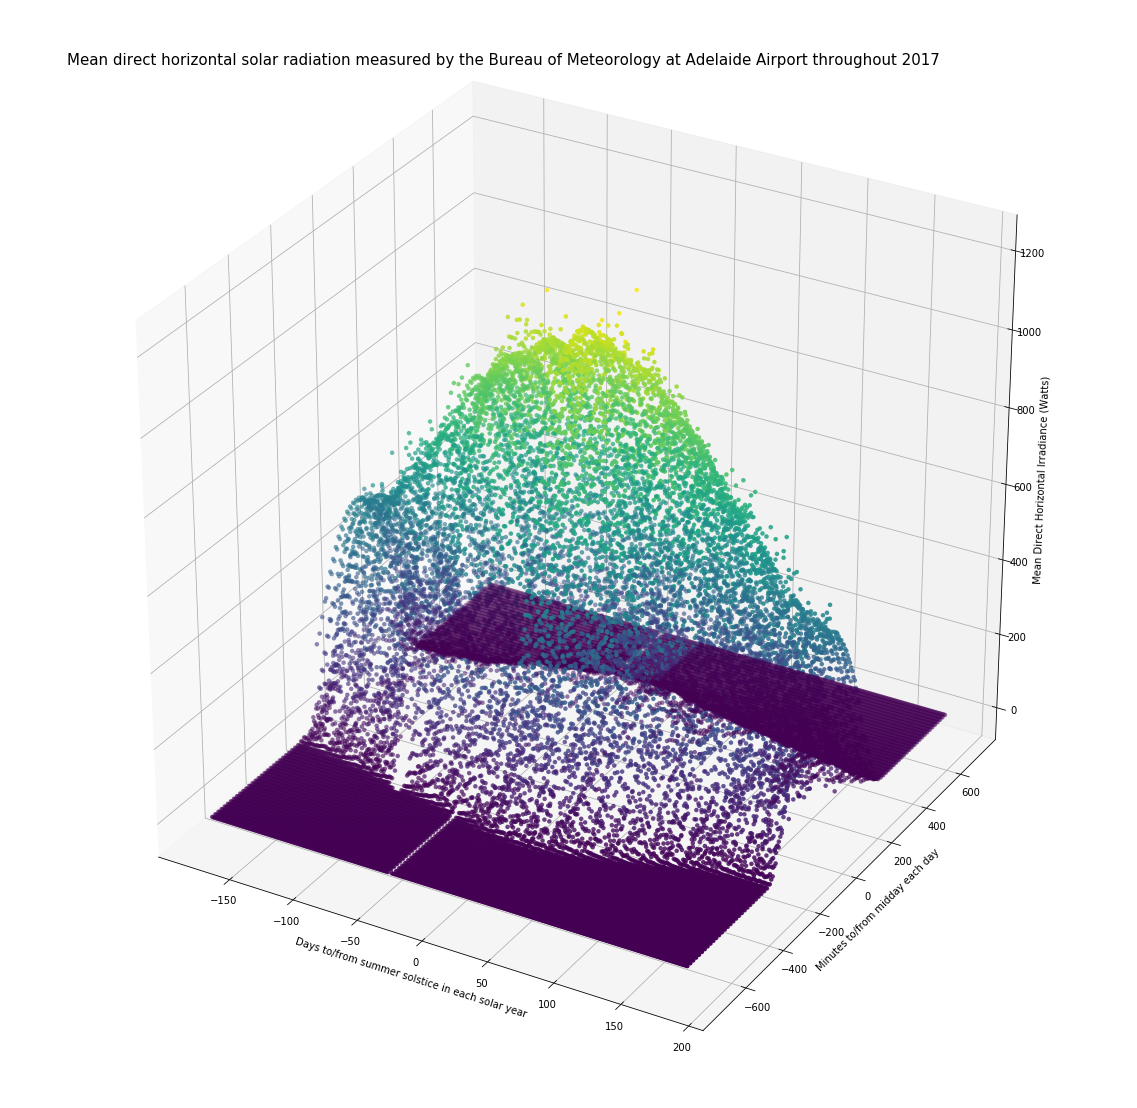

In [19]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_15M.summer_solstice_delta, PV_15M.midday_delta, PV_15M.GHI, 
                c=PV_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days to/from summer solstice in each solar year')
ax.set_ylabel('Minutes to/from midday each day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

__Observations:__

* Maximum solar power appears to consistently peak later than midday. Should we change the variable to reflect distance from the peak? - __No, model seems to work OK as long as the peak does not overlap the bounds each day or year.__
* Using a normal distribution to model changes in solar power by the day of the year, the tails appear to approach approximately 450 watts at the winter solstices, rather than zero (as might occur in the upper northern hemisphere). Does this make the normal distribution a poor fit to our data? - __When regressing to the mean, this does seem to be a problem.  Hopefully regression to the $q^th$ percentile will fix this.__

## Calculate 'clear sky' prediction of solar radiation at each minute of each day

Appendix A of 'Online short-term solar power forecasting' by Bache, Madsen & Nielsen, published in Solar Energy, Volume 83 (2009), pp.1772-1783, describes a method for calculating estimated clear sky solar power $\hat{p}_{t}^{cs}$ given a solar power time series $p_t$, $t=1$,...,$N$, found as the $q$ quantile of ${ {f}_{P} }_{t}$, which is the probability distribution function of $P_t$.  This should be a smooth function intersecting the maximums of the actual values $p_i$ on the diagram above.

The problem is reduced to estimating $\hat{p}_{t}^{cs}$ as a local constant for each $(x_t,y_t)$, where $x$ is the days since the start of the year and $y$ is the number of minutes since the start of the day.  

The loss function $\rho(q,\epsilon_i$) is:

\begin{equation*}
\rho(q,\epsilon_i) =
\begin{cases}
    q\epsilon_i ,\quad \quad \quad \epsilon_i >= 0,  \\
    (1 - q)\epsilon_i ,\quad \epsilon_i < 0, \\
\end{cases}
\end{equation*}

where:

\begin{equation*}
\epsilon_i = p_i - \hat{p}_{t}^{cs}
\end{equation*}

The fitting is done by:

\begin{equation*}
\underset{\hat{p}_{t}^{cs}}{\operatorname{arg min}} = \sum_{i=1}^N k(x_t,y_t,x_i,y_i)\cdot \rho(q,\epsilon_i),
\end{equation*}

where:

\begin{equation*}
k(x_t,y_t,x_i,y_i) = \frac{w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}{\sum_{i=1}^N w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}
\end{equation*}

is the two-dimensional multiplicative kernel function which weights the observations locally to $(x_t,y_t)$, following Hastie & Tibshirani's 'Varying-Coefficient Models' published in the Journal of the Royal Statistical Society. Series B (Methodological), Vol. 55, No. 4 (1993), pp. 757-796.

In each dimension a Gaussian kernel is used

\begin{equation*}
w(x_t,x_i,h_x) = f_{std}\left(\frac{\left|{x_t-x_i}\right|}{h_x}\right),
\end{equation*}

where $f_{std}$ is the standard normal probability density function. A similar kernel function is used in the $y$ dimension and the final two-dimensional kernel is found by multiplying the two kernels.

### Pack the (X) time of day and (Y) days since winter solstice variables into a single 3D array

In [79]:
X = PV_15M.summer_solstice_delta.values.reshape(365,96)
Y = PV_15M.midday_delta.values.reshape(365,96)
Z = PV_15M.GHI.values.reshape(365,96)

dim = (365,96)
pos = np.empty(dim + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [80]:
a = np.array(PV_15M[['summer_solstice_delta','midday_delta','GHI']])
a = a[np.argsort(a[:,0])]

#a = a[a[:,1].argsort()] # Sort by summer_solstice_delta
#a = a[a[:,0].argsort(kind='mergesort')] # Sort by midday_delta
a = a.reshape(365,96,3)

a[:, :, 1][1]

array([-255., -360., -345., -330., -315., -300., -285., -375., -270.,
       -240., -165., -210., -195., -180., -150., -135., -120., -105.,
        -90.,  -75., -390., -225., -405.,  705., -435.,  -60.,  690.,
       -720., -705., -690., -675., -660., -645., -630., -615., -600.,
       -585., -570., -555., -540., -525., -510., -495., -480., -465.,
       -450., -420.,  -45.,  345.,  -15.,  390.,  405.,  420.,  435.,
        450.,  465.,  480.,  495.,  510.,  375.,  525.,  555.,  570.,
        585.,  600.,  615.,  630.,  645.,  660.,  -30.,  540.,  360.,
        675.,    0.,   15.,   30.,   45.,   60.,   75.,   90.,  330.,
        120.,  135.,  150.,  105.,  180.,  165.,  300.,  285.,  270.,
        315.,  240.,  225.,  210.,  195.,  255.])

The following method easily creates arrays for the predictor variables; `summer_solstice_delta` and `midday_delta`.

In [81]:
X, Y = np.meshgrid(np.unique(PV_15M.midday_delta.values),
                   np.unique(PV_15M.summer_solstice_delta.values).astype(float))

In [23]:
iterables = [list(np.unique(PV_15M.summer_solstice_delta.values).astype(float)),
             list(np.unique(PV_15M.midday_delta.values))]

Groupby approach to create a Series of GHI values with a multi-index with two levels - (1) `summer_solstice_delta` and (2) `midday_delta`

In [85]:
a = PV_15M.groupby(['summer_solstice_delta','midday_delta'])['GHI']

In [87]:
a

In [88]:
Z = np.array(a.first().unstack()).T

In [89]:
Z.shape

(96, 365)

Visualise solar power output (GHI) after recentering the year to be at the summer solstice.

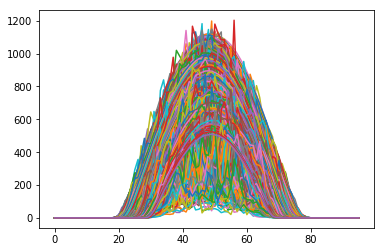

In [90]:
# Changes in stacked average 15 minute solar power throughout the year 
plt.plot(Z);

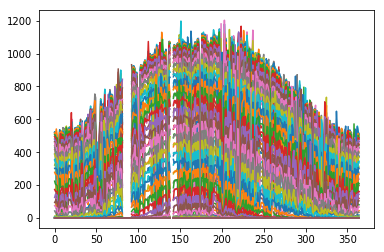

In [92]:
# Daily solar power throughout the day varying throughout the year
plt.plot(Z.T);

### Fit the normal distribution in 1 dimension

In [93]:
# One sunny day's actual data
y = Z[:,150]

In [94]:
x = ar(range(len(y)))

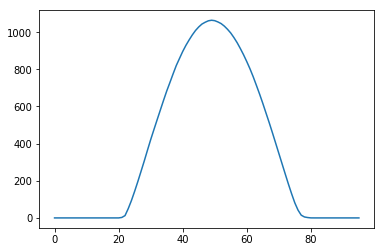

In [95]:
plt.plot(y);

In [96]:
mean = sum(x*y)/sum(y)
sigma = np.sqrt(sum(y*(y-mean)**2)/sum(y))

In [97]:
def gaus(x,a,x0,sigma):
    return a* np.exp(-(x-x0)**2/(2*sigma**2))

In [98]:
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

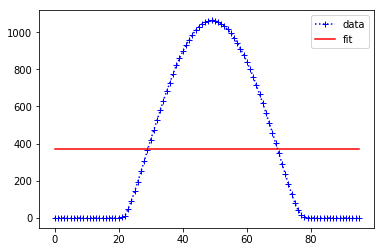

In [99]:
# Not working - but doesn't matter now that it is working in 2 dimensions
plt.plot(x, y, 'b+:', label='data')
plt.plot(x, gaus(x, *popt), 'r-', label='fit')
plt.legend()
plt.show;

### Example of bivariate normal distribution from [here](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)

In [100]:
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X_example = np.linspace(-600, 600, N)
Y_example = np.linspace(-160, 160, N)
X_example, Y_example = np.meshgrid(X_example, Y_example)

In [101]:
# Mean vector and covariance matrix
mu = np.array([0.4, .7])
Sigma = np.array([[ 6000. , -.5], [-.5, 18000.0]])

In [102]:
# Pack X and Y into a single 3-dimensional array
pos_example = np.empty(X_example.shape + (2,))
pos_example[:, :, 0] = X_example
pos_example[:, :, 1] = Y_example

In [103]:
from scipy.stats import multivariate_normal
F = multivariate_normal(mu, Sigma)
Z_hat_example = F.pdf(pos_example)

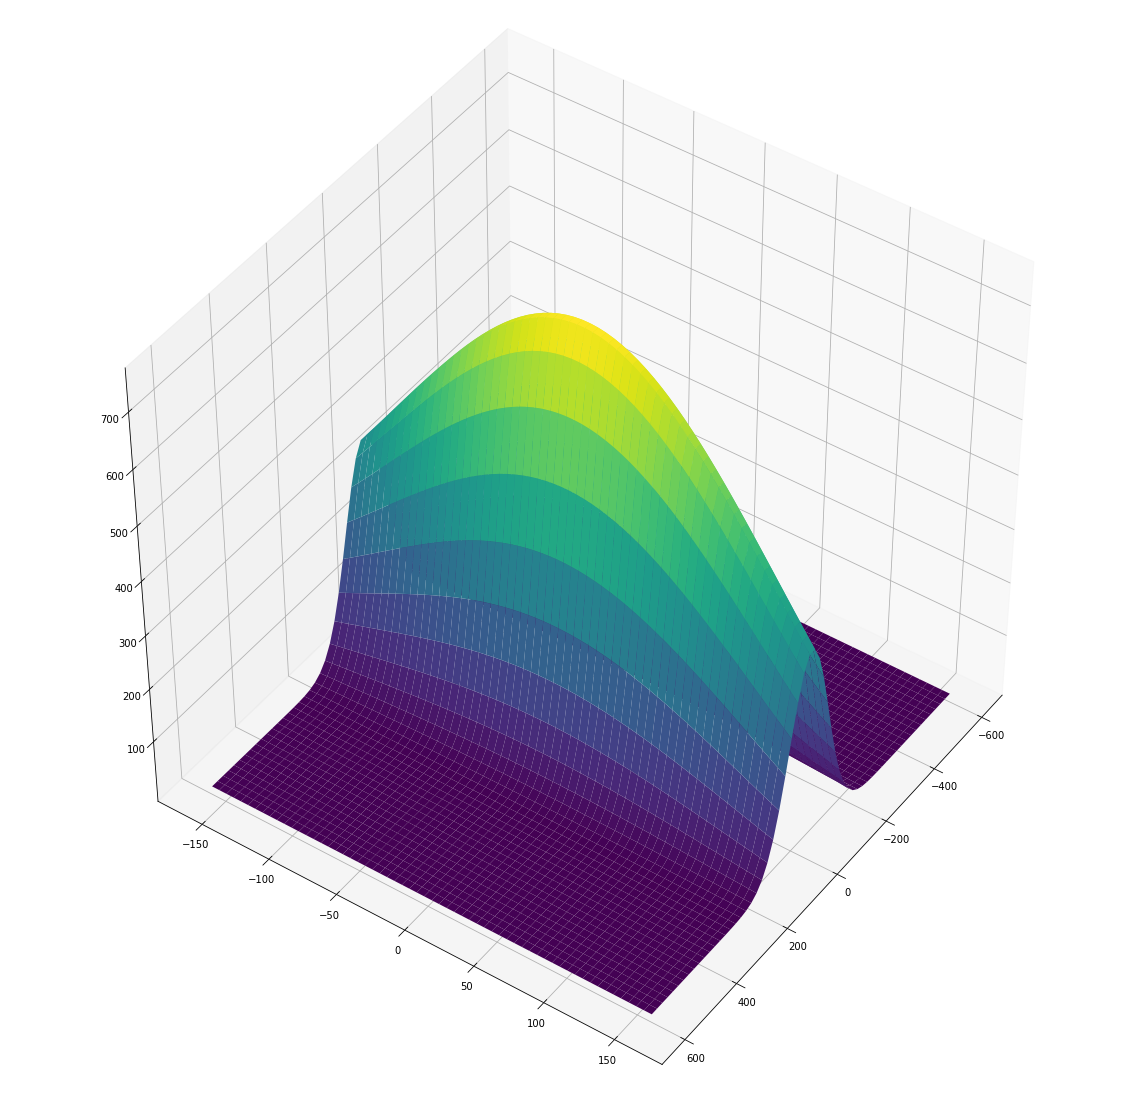

In [104]:
# Create a surface plot.
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot_surface(X_example, Y_example, Z_hat_example*5e7, 
                rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.view_init(45,35)
plt.show()

### Now expand to fit normal distribution in two dimensions

Function for 2D gaussian curve fitting taken from [here](https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m).

In [105]:
def twoD_gaus(xdata_tuple, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    x0 = float(x0)
    y0 = float(y0)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0)
                                     + c*((y-y0)**2)))
    return g.ravel()

In [106]:
x, y = np.meshgrid(np.unique(PV_15M.summer_solstice_delta.values),np.unique(PV_15M.midday_delta.values))

In [107]:
len(x)

96

In [108]:
# Replace missing values in Z with zero
Z = np.nan_to_num(Z,0)

In [109]:
Z.shape

(96, 365)

In [110]:
x.shape

(96, 365)

In [111]:
y.shape

(96, 365)

In [112]:
initial_guess = (3,100,100,20,40,0,10)

In [113]:
popt, pcov = curve_fit(twoD_gaus, (x,y), Z.ravel(), p0 = initial_guess, maxfev = 1000000)

In [114]:
popt

array([954.18835975,   3.38401239,  13.4988875 , 184.72904716,
       116.4614796 ,   7.80518412, -20.5760271 ])

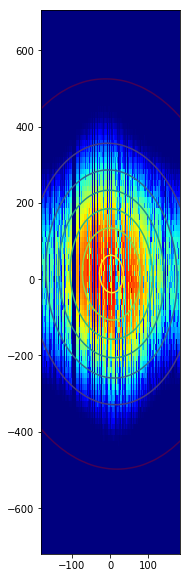

In [125]:
data_fitted = twoD_gaus((x,y), *popt)

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.imshow(Z, cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(96,365), 8)
plt.show();

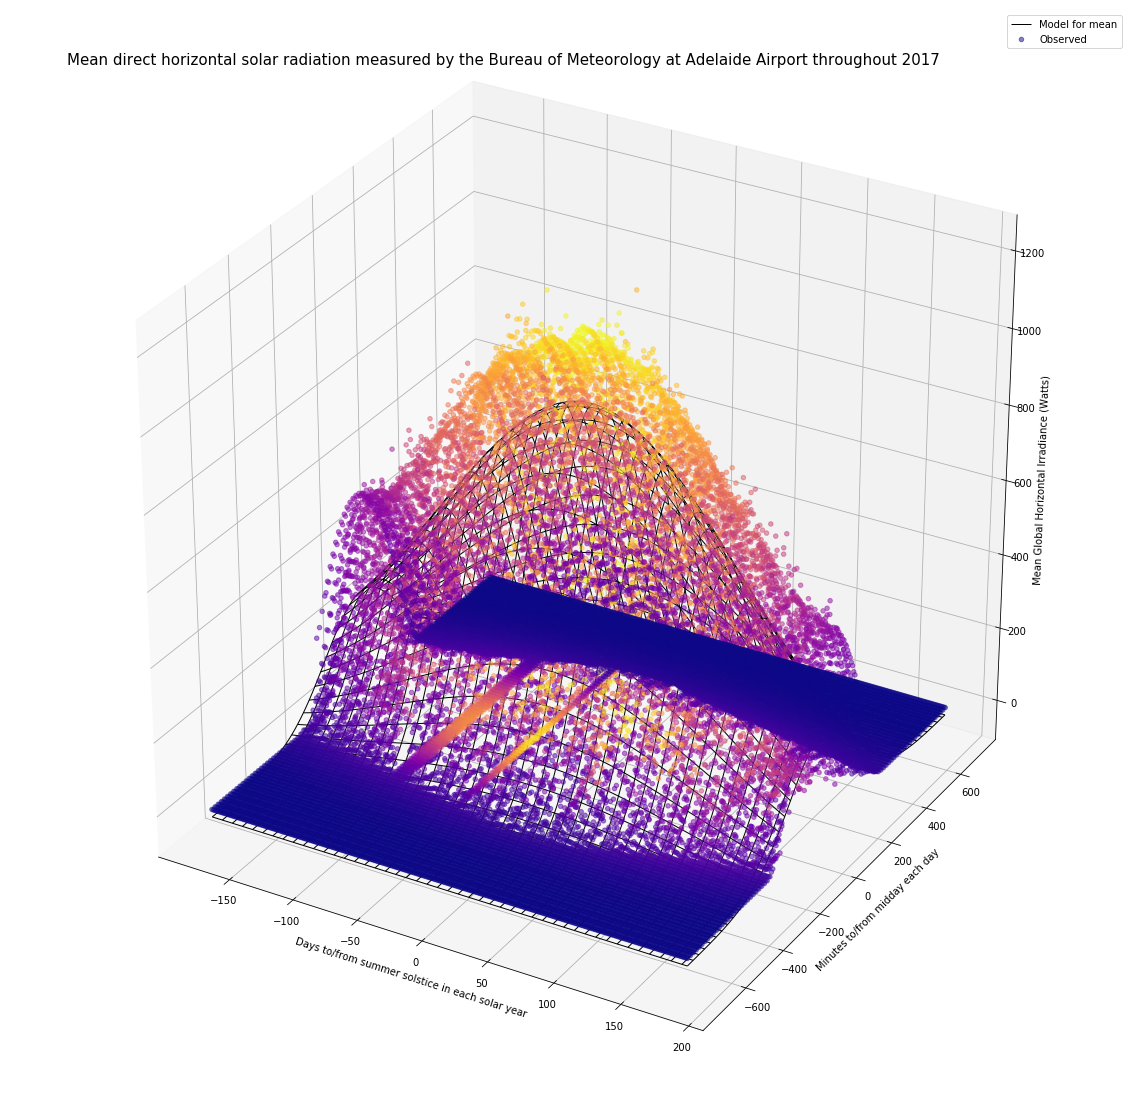

In [126]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.plot_wireframe(x, y, data_fitted.reshape(96,365), color='black', linewidth=1, label='Model for mean')
ax.scatter(x, y, Z, c=data_fitted, cmap=('plasma'), alpha=0.5, label='Observed')
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days to/from summer solstice in each solar year')
ax.set_ylabel('Minutes to/from midday each day')
ax.set_zlabel('Mean Global Horizontal Irradiance (Watts)')
plt.legend()
plt.show()

### Attempt to use scipy.optimize.minimise to vary mu and Sigma parameters to minimise MAE between observations and bivariate Gaussian regression plane (think about quantile regression component next...)

In [ ]:
PV_15M.summer_solstice_delta.nunique()

In [ ]:
PV_15M.midday_delta.nunique()

In [ ]:
parameters = [0.4, 0.7, 6000., -.5, 18000., 5e7]

In [ ]:
def create_Z_hat(params):
    mu_X = params[0]
    mu_Y = params[1]
    mu = np.array([mu_X, mu_Y])
    
    sigma_1 = params[2]
    sigma_2 = sigma_3 = params[3]
    sigma_4 = params[4]
    
    scale_up = params[5]
    
    Sigma = np.array([[sigma_1 , sigma_2], [sigma_2,  sigma_4]])
    model = multivariate_normal(mu, Sigma)      
    Z_hat = model.pdf(pos) # Probability distribution function
    Z_hat = Z_hat * scale_up # Scale up to have the same sum as Z
    return Z_hat

In [ ]:
Z_hat = create_Z_hat(params)

In [ ]:
def objective(params):
    return np.nansum(np.absolute(Z_hat - Z))

In [ ]:
pos.shape

In [ ]:
objective(params)

In [ ]:
def isPSD(params, tol=1e-8):
  E,V = scipy.linalg.eigvalsh(np.matrix(params[2:6]).reshape(2,2))
  return np.all(E > -tol)

In [ ]:
def constraint(params):
    return isPSD(params) + 1

In [ ]:
cons = {'type':'eq', 'fun': constraint}

In [ ]:
isPSD(params)

In [ ]:
solution = minimize(fun=objective,x0=params)

In [ ]:
help(minimize)

In [ ]:
solution

### Overlay regression plane with observed data

### Build quantile regression model predicting GHI from the number of minutes after the start of the day - based on __[the examples in the documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)__

In [ ]:
quantiles = np.arange(0.6,1,.025)

def fit_model(q):
    mod = smf.quantreg('GHI ~ midday_delta + summer_solstice_delta', PV_15M)
    res = mod.fit(q=q, kernel='gau')
    return [q, res.params['Intercept'], res.params['midday_delta']] + \
           res.conf_int().loc['midday_delta'].tolist()

models = [fit_model(y) for y in quantiles]
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])


In [ ]:
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])
models

In [ ]:
mod = smf.quantreg('GHI ~ gaus(midday_delta) + gaus(summer_solstice_delta)', PV_15M)

In [ ]:
res = mod.fit(q=0.85, kernel='gau')

In [ ]:
res.summary()

This does not appear to be fitting a normal distribution to the data.

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
curve_fit.

The headings for the output parameters are based on a linear regression. What do these represent and how can they be translated back into a normal distribution?

In [ ]:
QuantReg.from_formula()